In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images in grid format
def display_images(images, titles=None, cols=3, figsize=(15, 5)):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()


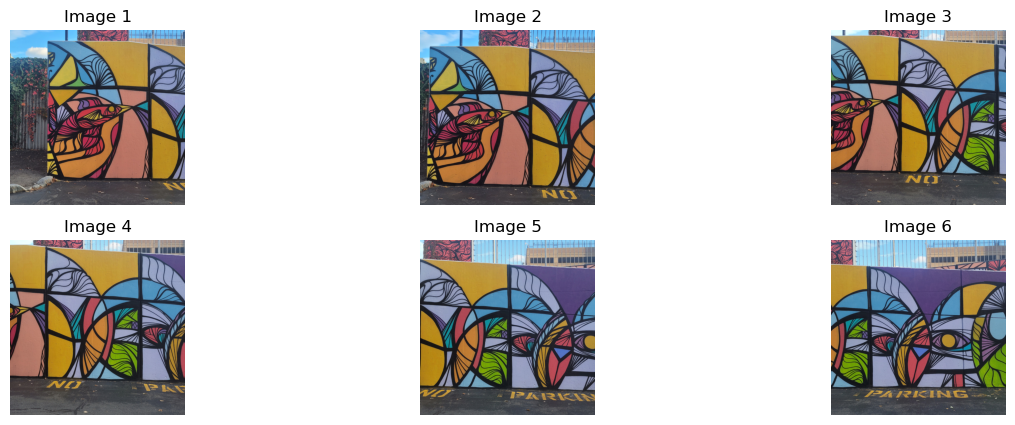

In [19]:
# Load images from paths and convert to RGB
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Unable to load image at path {path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

# Define paths to your images
image_paths = [
    "C:\\Users\\ragsh\\Desktop\\FALL 24\\RSN\\LAB5\\data\\image_1-1.jpg",
    "C:\\Users\\ragsh\\Desktop\\FALL 24\\RSN\\LAB5\\data\\image_2-1.jpg",
    "C:\\Users\\ragsh\\Desktop\\FALL 24\\RSN\\LAB5\\data\\image_3-1.jpg",
    "C:\\Users\\ragsh\\Desktop\\FALL 24\\RSN\\LAB5\\data\\image_4-1.jpg",
    "C:\\Users\\ragsh\\Desktop\\FALL 24\\RSN\\LAB5\\data\\image_5-1.jpg",
    "C:\\Users\\ragsh\\Desktop\\FALL 24\\RSN\\LAB5\\data\\image_6-1.jpg"
]

# Load images and display them
images = load_images(image_paths)
display_images(images, titles=[f"Image {i+1}" for i in range(len(images))])


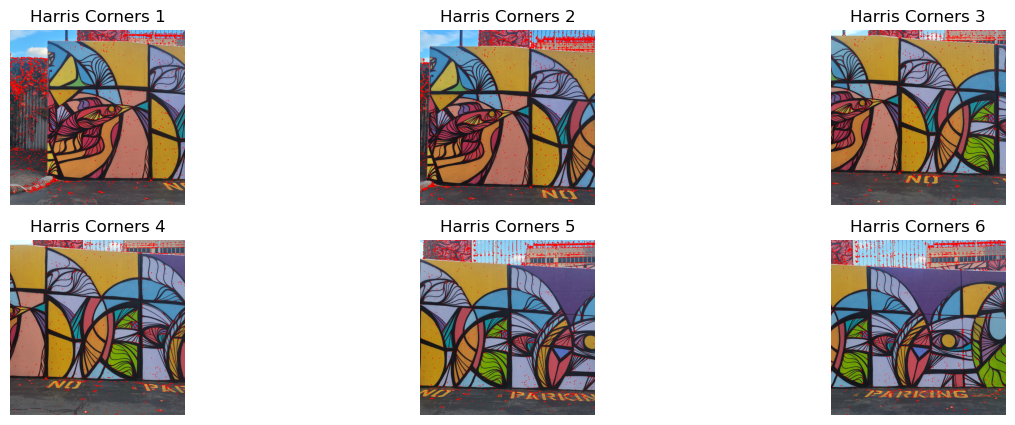

In [21]:
# Harris Corner Detection
def detect_harris_corners(image, threshold=0.01):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv2.dilate(harris_corners, None)
    corner_image = image.copy()
    corner_image[harris_corners > threshold * harris_corners.max()] = [255, 0, 0]
    return corner_image

# Detect Harris corners for each image
harris_images = [detect_harris_corners(img) for img in images]
display_images(harris_images, titles=["Harris Corners " + str(i+1) for i in range(len(harris_images))])


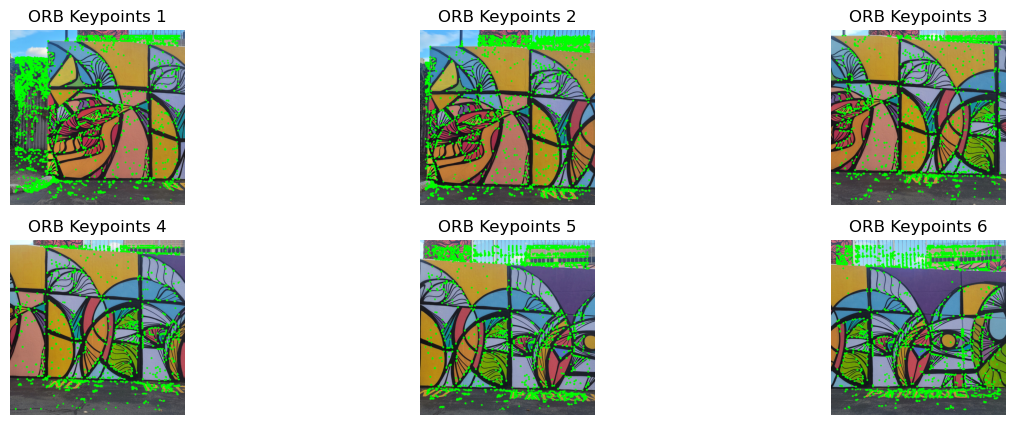

In [23]:
# Detect ORB Keypoints
def detect_orb_keypoints(image, harris_threshold=0.01, orb_features=1000):
    # First, detect Harris corners
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv2.dilate(harris_corners, None)

    # Extract strong corners above threshold
    keypoints = np.argwhere(harris_corners > harris_threshold * harris_corners.max())
    keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 1) for x in keypoints]

    # Compute descriptors for detected keypoints with ORB
    orb = cv2.ORB_create(nfeatures=orb_features)
    keypoints, descriptors = orb.compute(image, keypoints)
    keypoint_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))
    return keypoint_image, keypoints, descriptors

# Detect ORB keypoints for each image
orb_images = []
orb_keypoints_descriptors = []
for img in images:
    orb_image, keypoints, descriptors = detect_orb_keypoints(img)
    orb_images.append(orb_image)
    orb_keypoints_descriptors.append((keypoints, descriptors))

display_images(orb_images, titles=["ORB Keypoints " + str(i+1) for i in range(len(orb_images))])


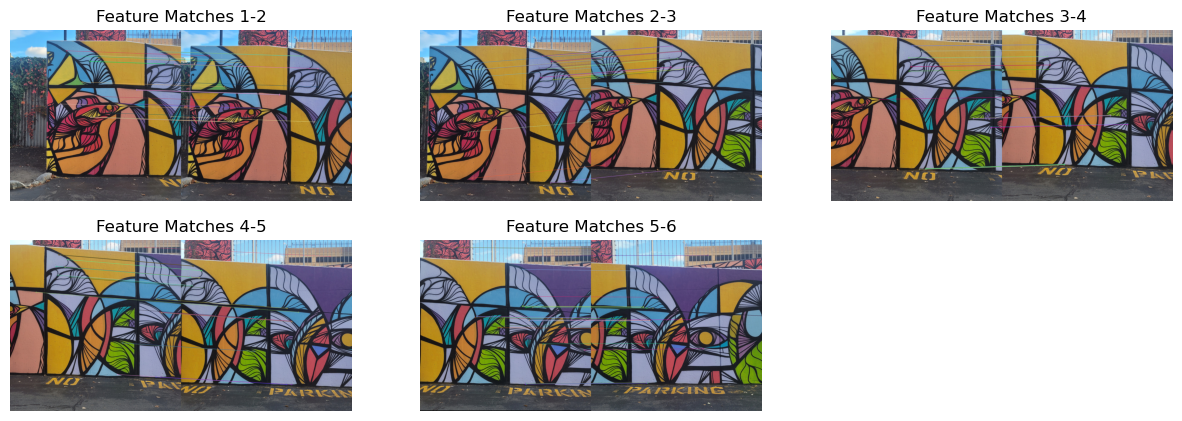

In [25]:
# Match features between consecutive image pairs
def match_features(image1, image2, keypoints1, descriptors1, keypoints2, descriptors2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    match_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return match_image, matches

# Display feature matches for consecutive pairs
match_images = []
for i in range(len(images) - 1):
    match_image, matches = match_features(
        images[i], images[i + 1],
        orb_keypoints_descriptors[i][0], orb_keypoints_descriptors[i][1],
        orb_keypoints_descriptors[i + 1][0], orb_keypoints_descriptors[i + 1][1]
    )
    match_images.append(match_image)

display_images(match_images, titles=["Feature Matches " + str(i+1) + "-" + str(i+2) for i in range(len(match_images))])


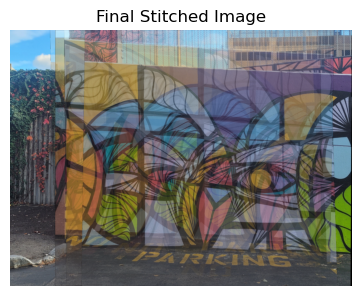

In [31]:
# Match features with a distance ratio test for more reliable matches
def match_features_ratio_test(image1, image2, keypoints1, descriptors1, keypoints2, descriptors2, ratio=0.75):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    # Visualize the matches if desired
    match_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return match_image, good_matches

# Updated stitching function using refined matches and homography
def stitch_images_refined(images, orb_keypoints_descriptors, ransac_thresh=5.0):
    # Start with the first image as the base
    stitched_image = images[0].copy()
    
    # Loop over each consecutive image
    for i in range(1, len(images)):
        keypoints1, descriptors1 = orb_keypoints_descriptors[i - 1]
        keypoints2, descriptors2 = orb_keypoints_descriptors[i]

        # Match features with a ratio test
        match_image, good_matches = match_features_ratio_test(
            stitched_image, images[i], keypoints1, descriptors1, keypoints2, descriptors2, ratio=0.75
        )

        # Check if there are enough good matches to proceed
        if len(good_matches) < 4:
            print(f"Not enough matches between images {i} and {i+1}")
            continue

        # Extract coordinates of matched points
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography with RANSAC to align images
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, ransac_thresh)

        # Warp the next image to align with the current stitched image
        height, width, _ = stitched_image.shape
        warped_image = cv2.warpPerspective(images[i], H, (width + images[i].shape[1], height))

        # Combine the stitched image and the warped image
        combined_image = np.zeros_like(warped_image)
        combined_image[:height, :width] = stitched_image

        # Blend overlapping regions
        overlap_region = np.where((combined_image != 0) & (warped_image != 0))
        combined_image[overlap_region] = (combined_image[overlap_region] // 2 + warped_image[overlap_region] // 2)

        # Add non-overlapping regions from warped image
        non_overlap_region = np.where((combined_image == 0) & (warped_image != 0))
        combined_image[non_overlap_region] = warped_image[non_overlap_region]

        # Update the stitched image
        stitched_image = combined_image
    
    # Crop out black borders from the final stitched panorama
    return crop_black_borders(stitched_image)

# Stitch the images with enhanced blending and ratio test
stitched_image = stitch_images_refined(images, orb_keypoints_descriptors)
display_images([stitched_image], titles=["Final Stitched Image"], figsize=(15, 8))
